In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Bank Customer Segmentation Analysis - Student Exercise

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [ ]:
# full implementation for the TODO functions
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def load_data(filepath="/content/bank-full.csv"):
    """
    Load bank dataset, preprocess:
      - drop duplicates / NA rows
      - one-hot encode categorical variables (drop_first=True)
      - scale all features with StandardScaler
    Returns:
      X_scaled (np.ndarray), df_original (pd.DataFrame), feature_names (list), scaler (object)
    """
    df = pd.read_csv(filepath)
    df = df.drop_duplicates().reset_index(drop=True)
    if df.isnull().sum().sum() > 0:
        df = df.dropna().reset_index(drop=True)

    # Separate categorical vs numeric then one-hot encode categoricals
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    if len(cat_cols) > 0:
        df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    else:
        df_enc = df.copy()

    feature_names = df_enc.columns.tolist()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_enc.values.astype(float))

    return X_scaled, df, feature_names, scaler


def apply_pca(x, n_components=2, random_state=42):
    """
    Apply PCA and return projected array, pca object, and explained variance ratio.
    x: array-like (n_samples, n_features)
    """
    pca = PCA(n_components=n_components, random_state=random_state)
    X_pca = pca.fit_transform(x)
    return X_pca, pca, pca.explained_variance_ratio_


def find_optimal_clusters(x, max_clusters=10, random_state=42):
    """
    Compute inertia (elbow) and silhouette for k in [1..max_clusters].
    Returns a dict with keys:
      - 'ks' : list of k
      - 'inertias' : list of inertia values
      - 'silhouettes' : list (silhouette for k>=2; np.nan for k=1)
    Prints a short summary and returns the dict.
    """
    ks = list(range(1, max_clusters + 1))
    inertias = []
    silhouettes = []

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10, max_iter=300)
        kmeans.fit(x)
        inertias.append(float(kmeans.inertia_))
        if k >= 2 and len(np.unique(kmeans.labels_)) >= 2 and x.shape[0] > k:
            try:
                s = silhouette_score(x, kmeans.labels_)
            except Exception:
                s = float('nan')
            silhouettes.append(float(s))
        else:
            silhouettes.append(float('nan'))

    result = {'ks': ks, 'inertias': inertias, 'silhouettes': silhouettes}
    print("Elbow / silhouette computed for k=1..{}".format(max_clusters))
    return result


def perform_kmeans_clustering(x, n_clusters=None, random_state=42):
    """
    Fit KMeans on x using specified n_clusters.
    Returns: model, labels (np.array), centroids (np.array), inertia (float), silhouette (float or nan)
    If n_clusters is None, raises ValueError.
    """
    if n_clusters is None:
        raise ValueError("n_clusters must be provided for perform_kmeans_clustering.")
    model = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10, max_iter=300)
    labels = model.fit_predict(x)
    centroids = model.cluster_centers_
    inertia = float(model.inertia_)
    sil = float('nan')
    if n_clusters >= 2 and len(np.unique(labels)) >= 2 and x.shape[0] > n_clusters:
        try:
            sil = silhouette_score(x, labels)
        except Exception:
            sil = float('nan')
    print(f"KMeans fitted with k={n_clusters}. Inertia={inertia:.2f}, Silhouette={sil if not np.isnan(sil) else 'N/A'}")
    return model, labels, centroids, inertia, sil


def perform_agglomerative_clustering(x, n_clusters=None, linkage_method='ward'):
    """
    Fit Agglomerative Clustering (sklearn) on x.
    Returns: model, labels (np.array)
    If n_clusters is None, raises ValueError.
    """
    if n_clusters is None:
        raise ValueError("n_clusters must be provided for perform_agglomerative_clustering.")
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
    labels = model.fit_predict(x)
    print(f"Agglomerative clustering fitted with k={n_clusters} and linkage='{linkage_method}'")
    return model, labels


def get_linkages(x, method='ward'):
    """
    Compute hierarchical clustering linkages for dendrogram.
    Returns: linkage matrix (scipy format)
    Note: ward requires Euclidean distances and will produce meaningful dendrogram for numeric scaled data.
    """
    # If x is large and plotting will be messy, consider sampling — but here we return linkage for all points.
    linked = linkage(x, method=method)
    return linked


def plot_dendrogram(linked, truncate_mode=None, p=30, figsize=(10, 6)):
    """
    Plot dendrogram from linkage matrix.
    - truncate_mode: None, 'level', or 'lastp'. If None, full dendrogram is plotted.
    - p: integer used with truncate_mode e.g. last p clusters
    """
    plt.figure(figsize=figsize)
    dendrogram(linked, truncate_mode=truncate_mode, p=p)
    plt.xlabel('Sample index or (cluster size)')
    plt.ylabel('Distance')
    plt.title('Hierarchical Clustering Dendrogram')
    plt.tight_layout()
    plt.show()

## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

def load_data(filepath):
    """Load and preprocess the bank marketing dataset.

    Steps:
    1. Load the CSV file (semicolon separator)
    2. Convert categorical columns to numerical using LabelEncoder
    3. Scale the selected features using StandardScaler
    """

    # 1. Load CSV with semicolon separator
    df = pd.read_csv(filepath, sep=';')

    # 2. Label encode categorical columns
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                        'loan', 'contact', 'month', 'poutcome', 'y']

    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    # 3. Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous',
                'job', 'education', 'housing', 'loan', 'default']

    X = df[features]

    # 4. Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, df

# Load and preprocess the data
X_scaled, data = load_data('bank-full.csv')
print("Data shape:", X_scaled.shape)

Data shape: (45211, 9)


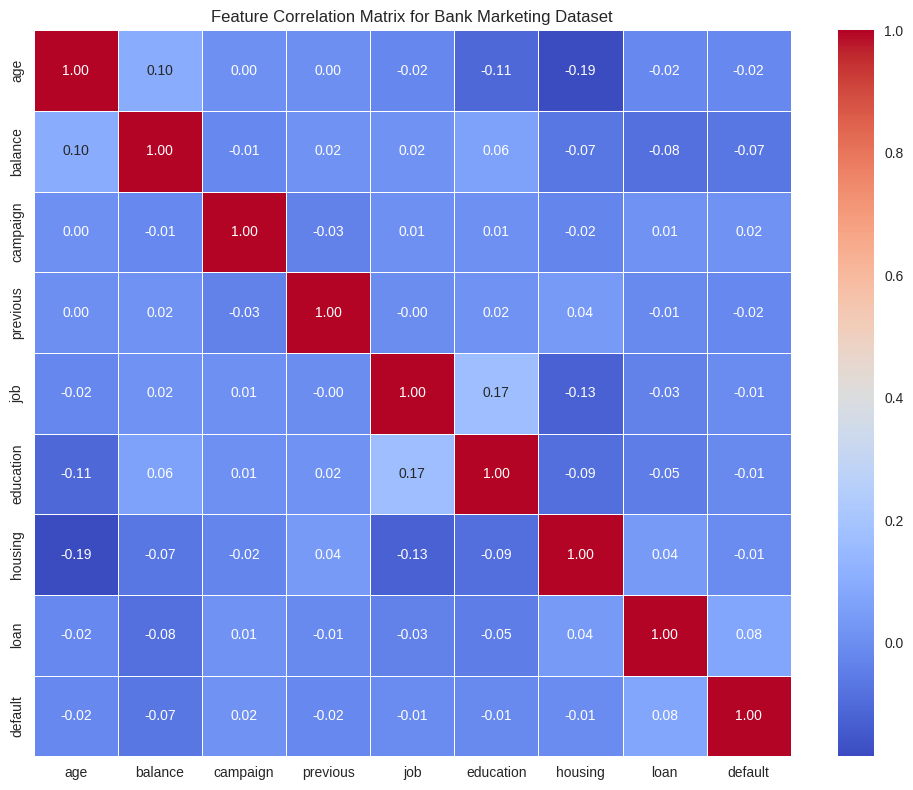

In [ ]:
# ================== FEATURE CORRELATION MATRIX ==================

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrame from the scaled features (X_scaled) with their feature names
df_corr = pd.DataFrame(X_scaled, columns=[
    'age', 'balance', 'campaign', 'previous',
    'job', 'education', 'housing', 'loan', 'default'
])

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix for Bank Marketing Dataset")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

class KMeansClustering:
    """Minimal K-means skeleton for students to implement."""

    def __init__(self, n_clusters=3, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Randomly pick n_clusters points from X as centroids."""
        np.random.seed(self.random_state)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]

    def _assign_clusters(self, X):
        """Assign each sample to nearest centroid based on Euclidean distance."""
        # Compute distance between every point and every centroid
        # X shape: (n_samples, n_features)
        # centroids shape: (n_clusters, n_features)
        distances = np.linalg.norm(X[:, None, :] - self.centroids[None, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        return labels

    def _update_centroids(self, X, labels):
        """Compute new centroids as mean of assigned points."""
        new_centroids = []
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) == 0:
                # If a cluster becomes empty → reinitialize randomly
                new_centroids.append(X[np.random.randint(0, X.shape[0])])
            else:
                new_centroids.append(cluster_points.mean(axis=0))
        return np.array(new_centroids)

    def fit(self, X):
        """Run K-means clustering algorithm."""
        self.centroids = self._initialize_centroids(X)

        for _ in range(self.max_iters):
            # Step 1: Assign clusters
            labels = self._assign_clusters(X)

            # Step 2: Compute updated centroids
            new_centroids = self._update_centroids(X, labels)

            # Stop if converged (centroids stop moving significantly)
            if np.allclose(self.centroids, new_centroids, atol=1e-4):
                break

            self.centroids = new_centroids

        self.labels = labels
        return self

    def predict(self, X):
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet. Call fit(X) first.")
        return self._assign_clusters(X)

## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

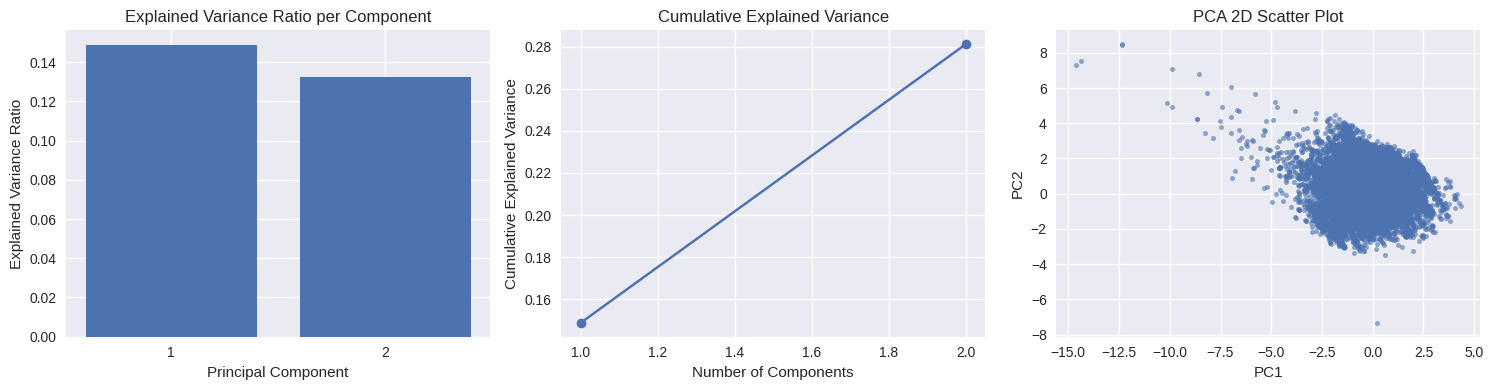

Shape after PCA: (45211, 2)


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction.

    Steps:
    1. Initialize and fit PCA
    2. Transform the data
    3. Visualize:
       - Explained variance ratio
       - Cumulative explained variance
       - 2D scatter of PCA-transformed data
    """

    # 1. Fit PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)

    # ---- Visualization ----
    plt.figure(figsize=(15, 4))

    # (A) Explained variance ratio (bar plot)
    plt.subplot(1, 3, 1)
    plt.bar(range(1, n_components + 1), explained_var)
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Explained Variance Ratio per Component")
    plt.xticks(range(1, n_components + 1))

    # (B) Cumulative explained variance
    plt.subplot(1, 3, 2)
    plt.plot(range(1, n_components + 1), cumulative_var, marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Cumulative Explained Variance")
    plt.grid(True)

    # (C) 2D scatter (if n_components = 2)
    plt.subplot(1, 3, 3)
    if n_components >= 2:
        plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.6)
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.title("PCA 2D Scatter Plot")
    else:
        plt.text(0.5, 0.5, "2D plot requires n_components ≥ 2",
                 ha='center', va='center')

    plt.tight_layout()
    plt.show()

    return X_pca

# Apply PCA
X_pca = apply_pca(X_scaled)
print("Shape after PCA:", X_pca.shape)

## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

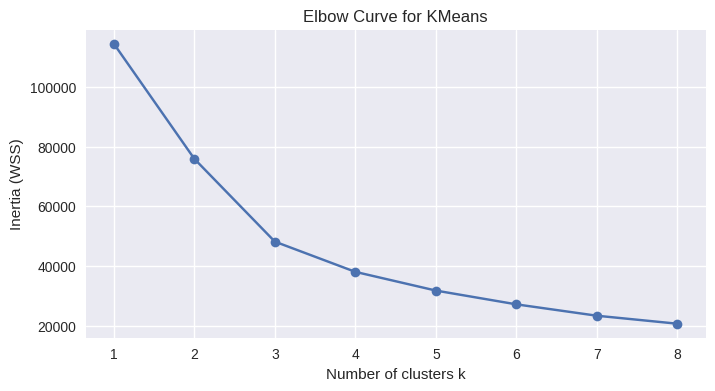

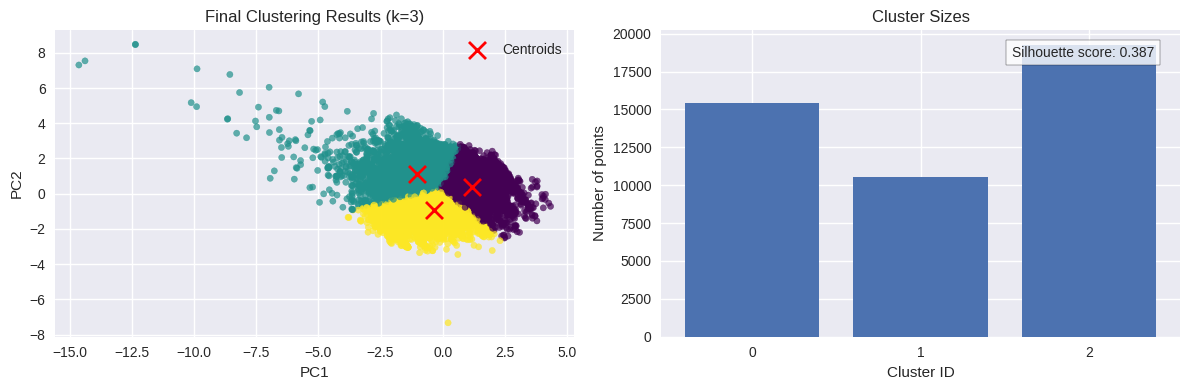


Clustering Evaluation:
Inertia: 48179.64
Silhouette Score: 0.3867


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

def calculate_inertia(X, labels, centroids):
    """Calculate the within-cluster sum of squares (inertia).

    1. For each cluster, calculate sum of squared distances between points and their centroid
    2. Sum up all cluster distances and return scalar inertia
    """
    inertia = 0.0
    labels = np.asarray(labels)
    centroids = np.asarray(centroids)
    # iterate over each cluster id
    for k in range(centroids.shape[0]):
        pts = X[labels == k]
        if pts.shape[0] == 0:
            continue
        # squared distances to centroid k
        dists_sq = np.sum((pts - centroids[k]) ** 2, axis=1)
        inertia += np.sum(dists_sq)
    return float(inertia)


def plot_elbow_curve(X, max_k=10, random_state=42):
    """Plot the elbow curve to find optimal number of clusters.

    1. Try different k values (1..max_k)
    2. Fit KMeansClustering and compute inertia for each k
    3. Plot k vs inertia and return list of inertias
    """
    inertias = []
    Ks = range(1, max_k + 1)
    for k in Ks:
        # For k=1, our KMeansClustering works; compute inertia after fit
        model = KMeansClustering(n_clusters=k, max_iters=200, random_state=random_state)
        model.fit(X)
        # compute inertia using centroids/labels
        inertia_k = calculate_inertia(X, model.labels, model.centroids)
        inertias.append(inertia_k)

    # plot elbow
    plt.figure(figsize=(8, 4))
    plt.plot(list(Ks), inertias, '-o')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Inertia (WSS)')
    plt.title('Elbow Curve for KMeans')
    plt.xticks(list(Ks))
    plt.grid(True)
    plt.show()

    return inertias

# Try different numbers of clusters (uses X_pca from earlier PCA step)
inertias = plot_elbow_curve(X_pca, max_k=8)

# Apply final clustering: choose k based on elbow (change if elbow suggests otherwise)
chosen_k = 3
kmeans = KMeansClustering(n_clusters=chosen_k, max_iters=300, random_state=42)
kmeans.fit(X_pca)

# Visualize final results
plt.figure(figsize=(12, 4))

# Plot clusters (scatter) with centroids
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis', s=20, alpha=0.7)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1],
            c='red', marker='x', s=150, linewidths=2, label='Centroids')
plt.title(f'Final Clustering Results (k={chosen_k})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Plot evaluation metrics: cluster sizes bar + silhouette annotation
plt.subplot(1, 2, 2)
unique, counts = np.unique(kmeans.labels, return_counts=True)
plt.bar(unique.astype(str), counts)
plt.xlabel('Cluster ID')
plt.ylabel('Number of points')
plt.title('Cluster Sizes')

# compute silhouette (only if valid)
sil = float('nan')
if chosen_k >= 2 and len(np.unique(kmeans.labels)) >= 2 and X_pca.shape[0] > chosen_k:
    try:
        sil = silhouette_score(X_pca, kmeans.labels)
    except Exception:
        sil = float('nan')

# annotate silhouette on the bar plot
txt = f"Silhouette score: {sil:.3f}" if not np.isnan(sil) else "Silhouette score: N/A"
plt.text(0.95, 0.95, txt, horizontalalignment='right',
         verticalalignment='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))

plt.tight_layout()
plt.show()

# Calculate and print evaluation metrics
inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)
silhouette = sil if not np.isnan(sil) else None

print("\nClustering Evaluation:")
print(f"Inertia: {inertia:.2f}")
if silhouette is not None:
    print(f"Silhouette Score: {silhouette:.4f}")
else:
    print("Silhouette Score: N/A (requires >=2 clusters and sufficient samples)")

## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

class BisectingKMeans:
    """
    Bisecting K-Means with a built-in plotting helper.
    Use fit_predict(X) to compute labels, then call plot(X) to visualize.
    """
    def __init__(self, n_clusters, random_state=42):
        if n_clusters < 1:
            raise ValueError("n_clusters must be >= 1")
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.labels_ = None
        self.split_tree = {}
        self.centers_ = {}

    def _compute_centroid(self, X, indices):
        """Helper: compute centroid of X[indices]."""
        if len(indices) == 0:
            return None
        return X[indices].mean(axis=0)

    def fit_predict(self, X):
        """
        Fit bisecting k-means and return labels.
        X: array-like (n_samples, n_features)
        """
        X = np.asarray(X)
        n_samples = X.shape[0]

        # start: all points in cluster 0
        labels = np.zeros(n_samples, dtype=int)
        next_label = 1  # next new label id to assign
        self.split_tree = {}
        self.centers_ = {0: self._compute_centroid(X, np.arange(n_samples))}

        # If only 1 cluster requested, return all zeros
        if self.n_clusters == 1:
            self.labels_ = labels
            return labels

        # Loop until we have desired number of clusters or can't split further
        while len(np.unique(labels)) < self.n_clusters:
            # find largest cluster by size (could also use SSE)
            unique, counts = np.unique(labels, return_counts=True)
            sizes = dict(zip(unique, counts))
            # choose cluster id with maximum size
            cluster_to_split = max(sizes.items(), key=lambda kv: kv[1])[0]

            # indices of points in that cluster
            idx = np.where(labels == cluster_to_split)[0]
            if len(idx) <= 1:
                # cannot split a singleton cluster; try to find next-largest that can be split
                splittable = [cid for cid in unique if np.sum(labels==cid) > 1]
                if not splittable:
                    # nothing left to split
                    break
                cluster_to_split = max(splittable, key=lambda c: np.sum(labels==c))
                idx = np.where(labels == cluster_to_split)[0]

            # Run binary kmeans on subset
            kmeans = KMeans(n_clusters=2, random_state=self.random_state, n_init=10, max_iter=300)
            subX = X[idx]
            child_labels = kmeans.fit_predict(subX)

            # choose which child keeps the old label and which gets the new id
            keep_child = 0
            new_child = 1
            keep_indices = idx[child_labels == keep_child]
            new_indices = idx[child_labels == new_child]

            # Assign labels: new_indices get next_label; keep_indices keep original label
            labels[new_indices] = next_label

            # Record split in tree and update centers
            self.split_tree[cluster_to_split] = (cluster_to_split, next_label)
            self.centers_[cluster_to_split] = self._compute_centroid(X, keep_indices)
            self.centers_[next_label] = self._compute_centroid(X, new_indices)

            next_label += 1

            # Safety: if we reached required number of clusters, break
            if len(np.unique(labels)) >= self.n_clusters:
                break

        # Remap cluster ids to a compact range 0..k-1 for convenience
        unique_ids = sorted(np.unique(labels))
        id_map = {old: new for new, old in enumerate(unique_ids)}
        compact_labels = np.vectorize(id_map.get)(labels)

        # Remap centers_ accordingly
        new_centers = {}
        for old_id, centroid in self.centers_.items():
            if old_id in id_map:
                new_centers[id_map[old_id]] = centroid
        self.centers_ = new_centers

        # Rebuild split_tree with compact ids (optional)
        new_tree = {}
        for parent, (a, b) in self.split_tree.items():
            if parent in id_map and a in id_map and b in id_map:
                new_tree[id_map[parent]] = (id_map[a], id_map[b])
        self.split_tree = new_tree

        self.labels_ = compact_labels
        return self.labels_

    def plot(self, X, figsize=(12,5), cmap='tab10', show_centroids=True, title=None):
        """
        Visualize bisecting KMeans results on 2D data X (e.g. X_pca).
        - X: array-like shape (n_samples, 2) (recommended 2D PCA for plotting)
        - Produces: PCA scatter colored by labels, centroids, cluster sizes bar plot,
                    prints split_tree and silhouette score.
        """
        if self.labels_ is None:
            raise ValueError("No labels found. Run fit_predict(X) first.")

        import matplotlib.pyplot as plt
        from sklearn.metrics import silhouette_score
        X = np.asarray(X)

        labels = self.labels_
        unique, counts = np.unique(labels, return_counts=True)

        # Centroids: ensure sorted by label 0..k-1
        centroids = np.array([self.centers_[i] for i in sorted(self.centers_.keys())])

        plt.figure(figsize=figsize)

        # Scatter + centroids
        plt.subplot(1,2,1)
        sc = plt.scatter(X[:,0], X[:,1], c=labels, cmap=cmap, s=12, alpha=0.7)
        if show_centroids and len(centroids) > 0:
            plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='X', s=150, edgecolor='k', label='Centroids')
        plt.xlabel('PC1'); plt.ylabel('PC2')
        plt.title(title or f'Bisecting KMeans (k={self.n_clusters})')
        plt.legend(loc='upper right')
        plt.grid(alpha=0.2)

        # Cluster sizes bar
        plt.subplot(1,2,2)
        plt.bar(unique.astype(str), counts)
        plt.xlabel('Cluster ID'); plt.ylabel('Count')
        plt.title('Cluster sizes')

        plt.tight_layout()
        plt.show()

        # Print tree and centroids
        print("Split tree (parent -> (left_keep, right_new)):", self.split_tree)
        print("\nCentroids (cluster_id: centroid coords):")
        for cid in sorted(self.centers_.keys()):
            print(f"  {cid}: {np.round(self.centers_[cid], 4)}")

        # Silhouette if valid
        if len(np.unique(labels)) >= 2:
            try:
                sil = silhouette_score(X, labels)
                print(f"\nSilhouette score (bisecting, k={len(np.unique(labels))}): {sil:.4f}")
            except Exception:
                print("\nSilhouette score: could not compute")
        else:
            print("\nSilhouette score: N/A (need >=2 clusters)")

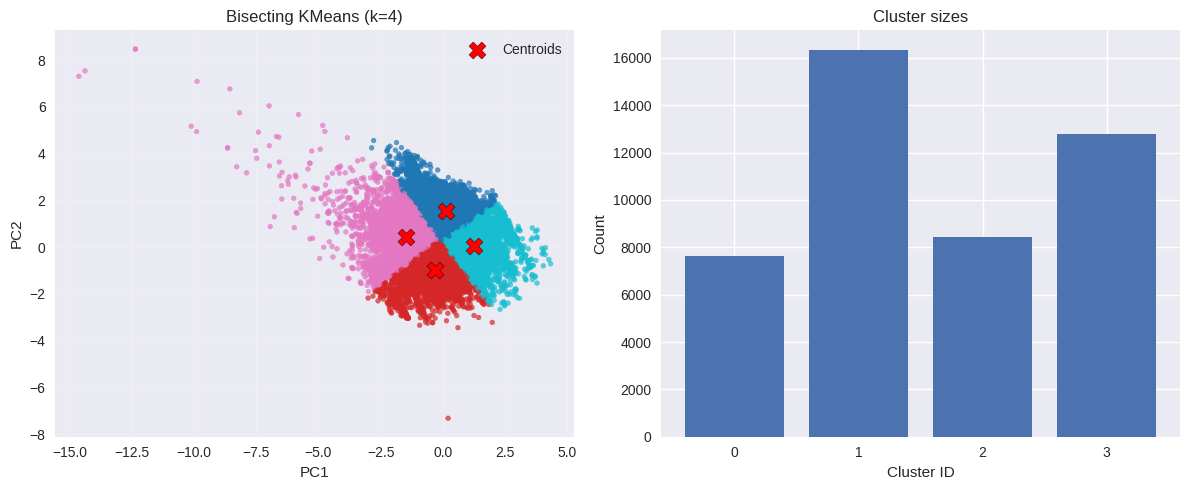

Split tree (parent -> (left_keep, right_new)): {0: (0, 3), 1: (1, 2)}

Centroids (cluster_id: centroid coords):
  0: [0.149  1.5371]
  1: [-0.2956 -0.976 ]
  2: [-1.481   0.4119]
  3: [1.2643 0.0579]

Silhouette score (bisecting, k=4): 0.3602


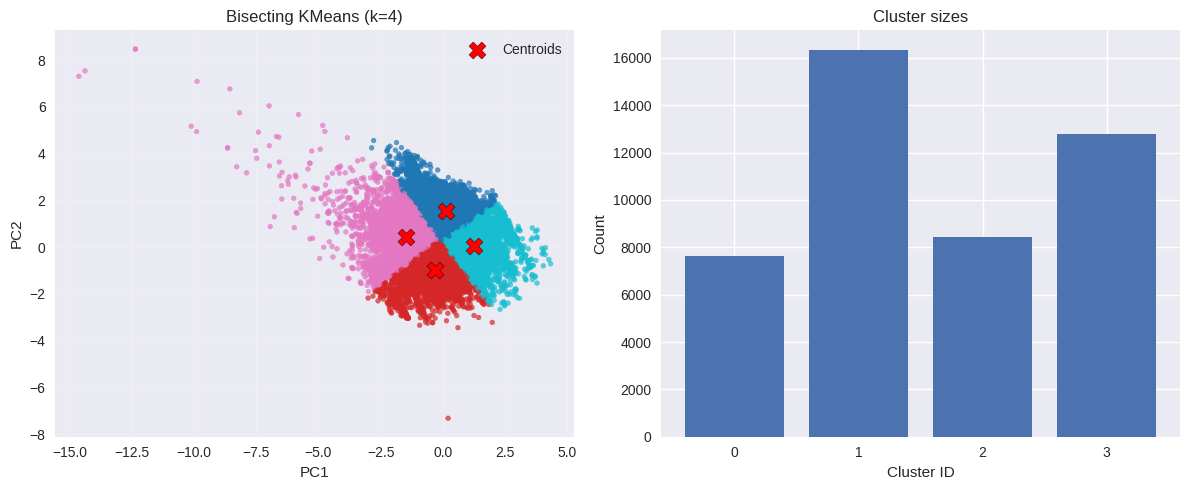


Saved bisecting plot to: /content/bisecting_kmeans.png

Split tree (parent -> (left_keep, right_new)):
 {0: (0, 3), 1: (1, 2)}

Centroids (cluster_id -> coords):
  0: [0.14904682 1.53710575]
  1: [-0.29559068 -0.97598053]
  2: [-1.48097889  0.41191657]
  3: [1.26431565 0.05793936]

Silhouette score: 0.3602


In [ ]:
# ======= Run and plot Bisecting KMeans (paste this after X_pca is available) =======
import os

# sanity check: X_pca should exist and be 2D
try:
    X_pca.shape
except NameError:
    raise RuntimeError("X_pca not found. Run PCA cell first before this cell.")

# Choose how many clusters you want from bisecting
target_k = 4   # <- change this (3,4,5 etc.) depending on what you want to explore

# Run bisecting
bisect = BisectingKMeans(n_clusters=target_k, random_state=42)
labels_bisect = bisect.fit_predict(X_pca)

# Plot to screen and save figure
bisect.plot(X_pca, title=f'Bisecting KMeans (k={target_k})')

# Save the same figure programmatically: re-create and save to file
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

# left: scatter + centroids
plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_bisect, cmap='tab10', s=12, alpha=0.7)
centroids = np.array([bisect.centers_[i] for i in sorted(bisect.centers_.keys())])
if len(centroids) > 0:
    plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='X', s=150, edgecolor='k', label='Centroids')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title(f'Bisecting KMeans (k={target_k})')
plt.legend(loc='upper right')
plt.grid(alpha=0.2)

# right: cluster sizes
plt.subplot(1,2,2)
unique, counts = np.unique(labels_bisect, return_counts=True)
plt.bar(unique.astype(str), counts)
plt.xlabel('Cluster ID'); plt.ylabel('Count')
plt.title('Cluster sizes')

plt.tight_layout()
out_path = "bisecting_kmeans.png"
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved bisecting plot to: {os.path.abspath(out_path)}")

# Print split-tree / centroids / silhouette for report
from sklearn.metrics import silhouette_score
print("\nSplit tree (parent -> (left_keep, right_new)):\n", bisect.split_tree)
print("\nCentroids (cluster_id -> coords):")
for cid in sorted(bisect.centers_.keys()):
    print(f"  {cid}: {bisect.centers_[cid]}")
if len(np.unique(labels_bisect)) >= 2:
    print("\nSilhouette score:", round(silhouette_score(X_pca, labels_bisect), 4))
else:
    print("\nSilhouette score: N/A (need >=2 clusters)")

## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!